# 3D Molchanov - MLflow

In [1]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Load Data

In [2]:
from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

In [3]:
import os

import pandas as pd

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Train/Test split

In [4]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

### Pre-processing functions

In [5]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


### Parameters

In [6]:
BATCH_SIZE = 64
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 30
LR = 0.001

In [7]:
from recognizer.dataset import SampledVideoDataset

training_dataset = SampledVideoDataset(
    video_filenames=training_set["file"].values,
    labels=training_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

testing_dataset = SampledVideoDataset(
    video_filenames=testing_set["file"].values,
    labels=testing_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

print(f"Training/testing set: ({len(training_dataset)}, {len(testing_dataset)})")

Training/testing set: (2560, 640)


### Data Loaders

In [8]:
import torch 
from torch import nn

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = True)

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

In [9]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

device

'cuda'

### Model

In [23]:
from recognizer.models.molchanov_3d import Molchanov3DCNN

model = Molchanov3DCNN(
    num_classes=NUM_CLASSES,
    num_frames=NUM_FRAMES,
    batch_size=BATCH_SIZE,
)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

loss_function = nn.CrossEntropyLoss()

In [24]:
dummy_input = torch.randn(24, 3, 16, 216, 384).cuda()

output = model(dummy_input)

print("Output shape:", output.shape)  # Should be [24, 64]

Output shape: torch.Size([24, 64])


In [25]:
p = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Params: {p}")

Params: 4896102


In [13]:
for n, p in model.named_parameters():
    print(f"Param: {n} | Shape: {p.shape}")

Param: conv_layer_1.0.weight | Shape: torch.Size([3, 3, 5, 5, 5])
Param: conv_layer_1.0.bias | Shape: torch.Size([3])
Param: conv_layer_2.0.weight | Shape: torch.Size([5, 3, 3, 3, 3])
Param: conv_layer_2.0.bias | Shape: torch.Size([5])
Param: fc_layer.0.weight | Shape: torch.Size([100, 48880])
Param: fc_layer.0.bias | Shape: torch.Size([100])
Param: fc_layer.3.weight | Shape: torch.Size([64, 100])
Param: fc_layer.3.bias | Shape: torch.Size([64])


## Set Up Experiment in MLflow

In [14]:
import mlflow
import os

from mlflow.entities import Experiment
from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_SERVER_URI = "http://localhost:5001"

os.environ["AWS_ACCESS_KEY_ID"] = "miniouser"
os.environ["AWS_SECRET_ACCESS_KEY"] = "miniopass"
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://localhost:9000/"

mlflow.set_tracking_uri(MLFLOW_TRACKING_SERVER_URI)
mlflow_client = MlflowClient(MLFLOW_TRACKING_SERVER_URI)

In [15]:
EXPERIMENT_NAME = "3D Molchanov 01"

experiment: Experiment = mlflow.set_experiment(experiment_name=EXPERIMENT_NAME)

In [16]:
RUN_NAME = "Execution 05"

run = None

matching_runs = mlflow_client.search_runs(
    experiment_ids=[experiment.experiment_id],
    filter_string=f"tags.mlflow.runName = '{RUN_NAME}'"
)

if len(matching_runs) > 0:
    raise Exception("Pisando run existente!!!!!")

run = mlflow_client.create_run(experiment_id=experiment.experiment_id)

mlflow_client.set_tag(run_id=run.info.run_id, key="mlflow.runName", value=RUN_NAME)

print(f"Run '{RUN_NAME}' creado con ID '{run.info.run_id}'")

Run 'Execution 05' creado con ID '000a69c152cc46eb87672bbfbbcb7c48'


### Log Params

In [17]:
mlflow_client.log_param(run_id=run.info.run_id, key="BATCH_SIZE", value=BATCH_SIZE)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_CLASSES", value=NUM_CLASSES)
mlflow_client.log_param(run_id=run.info.run_id, key="EPOCHS", value=EPOCHS)
mlflow_client.log_param(run_id=run.info.run_id, key="NUM_FRAMES", value=NUM_FRAMES)
mlflow_client.log_param(run_id=run.info.run_id, key="LR", value=LR)

print("Params successfully logged")

Params successfully logged


In [18]:
mlflow_client.log_text(run_id=run.info.run_id, text=str(testing_set.index.values), artifact_file="testing set index.txt")

INFO:botocore.credentials:Found credentials in environment variables.


## Training

In [19]:
import subprocess

CMD = '''
on run argv
  display notification (item 2 of argv) with title (item 1 of argv) sound name "Glass"
end run
'''

def notify(title, text):
    subprocess.call(['osascript', '-e', CMD, title, text])

In [22]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

cm = None

metrics = {
    "training_loss": [],
    "testing_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1": []
}

In [26]:
print(
f"""
Beginning model training with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
"""
)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} - Training phase")

    model.train()

    running_training_loss = 0.0

    for _, data in enumerate(train_loader):

        batch, labels = data[0].to(device), data[1].to(device)

        logits = model(batch)

        loss = loss_function(logits, labels)

        running_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_training_loss = running_training_loss / len(train_loader)
    metrics["training_loss"].append(round(average_training_loss, 2))

    print(f"    - AVG Training Loss: {average_training_loss:.2f}")

    # Evaluation
    print(f"Epoch {epoch + 1} - Evaluation phase")

    model.eval()

    all_preds = []
    all_targets = []

    running_testing_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            logits = model(inputs)

            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.detach().cpu())
            all_targets.extend(labels.detach().cpu())

            loss = loss_function(logits, labels)
            running_testing_loss += loss.item()

    average_testing_loss = running_testing_loss / len(test_loader)
    metrics["testing_loss"].append(round(average_testing_loss, 2))

    print(f"    - AVG Testing Loss: {average_testing_loss:.2f}")

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    metrics["accuracy"].append(accuracy_score(all_targets, all_preds))
    metrics["precision"].append(precision_score(all_targets, all_preds, average="macro"))
    metrics["recall"].append(recall_score(all_targets, all_preds, average="macro"))
    metrics["f1"].append(f1_score(all_targets, all_preds, average="macro"))

    for metric in metrics.keys():
        mlflow_client.log_metric(
            run_id=run.info.run_id,
            key=metric,
            value=metrics[metric][epoch],
            step=epoch,
        )

    if epoch == EPOCHS - 1:
        cm = confusion_matrix(all_targets, all_preds)

    print(f"""
    - Accuracy  : {metrics['accuracy'][-1]}
    - Precision : {metrics['precision'][-1]}
    - Recall    : {metrics['recall'][-1]}
    - F1        : {metrics['f1'][-1]}
    """)


Beginning model training with parameters:
- Epochs: 30
- Batch Size: 64

Epoch 1 - Training phase
    - AVG Training Loss: 3.52
Epoch 1 - Evaluation phase
    - AVG Testing Loss: 2.26


c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    - Accuracy  : 0.478125
    - Precision : 0.5145147075898817
    - Recall    : 0.478125
    - F1        : 0.4431185618813558
    
Epoch 2 - Training phase
    - AVG Training Loss: 1.39
Epoch 2 - Evaluation phase
    - AVG Testing Loss: 0.49

    - Accuracy  : 0.8796875
    - Precision : 0.8939467650405151
    - Recall    : 0.8796875
    - F1        : 0.8804406786724814
    
Epoch 3 - Training phase
    - AVG Training Loss: 0.33
Epoch 3 - Evaluation phase
    - AVG Testing Loss: 0.41

    - Accuracy  : 0.90625
    - Precision : 0.9164450566794318
    - Recall    : 0.9062500000000001
    - F1        : 0.907202397462695
    
Epoch 4 - Training phase
    - AVG Training Loss: 0.18
Epoch 4 - Evaluation phase
    - AVG Testing Loss: 0.30

    - Accuracy  : 0.9296875
    - Precision : 0.9373579545454546
    - Recall    : 0.9296875
    - F1        : 0.9299451873053848
    
Epoch 5 - Training phase
    - AVG Training Loss: 0.10
Epoch 5 - Evaluation phase
    - AVG Testing Loss: 0.27

    - A

## Evaluation

### Confusion Matrix

In [27]:
cm = confusion_matrix(all_targets, all_preds)

<AxesSubplot: >

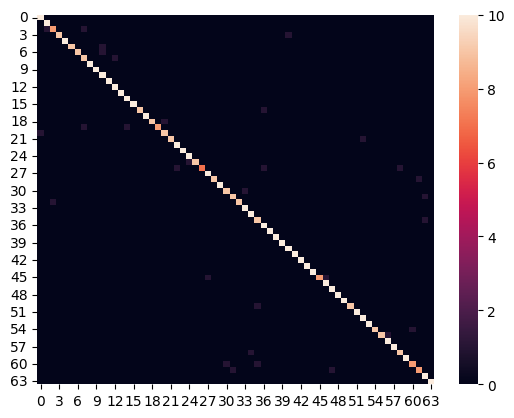

In [28]:
import seaborn as sns

sns.heatmap(data=cm)

### Accuracy/Recall/Precision

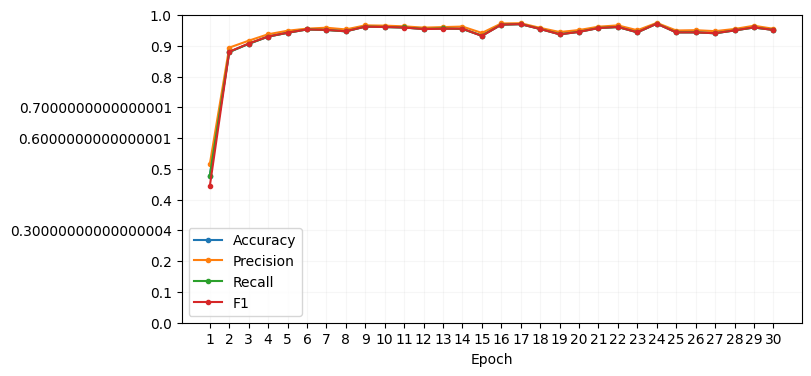

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["accuracy"], label="Accuracy", marker=".")
ax.plot(metrics["precision"], label="Precision", marker=".")
ax.plot(metrics["recall"], label="Recall", marker=".")
ax.plot(metrics["f1"], label="F1", marker=".")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

### Loss

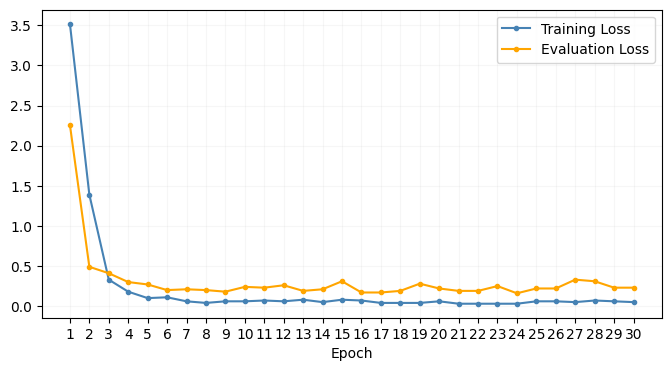

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(metrics["training_loss"], label="Training Loss", marker=".", color="steelblue")
ax.plot(metrics["testing_loss"], label="Evaluation Loss", marker=".", color="orange")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

## Save model

In [31]:
import copy
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

MODEL_PATH = MODELS_DIR / f"{EXPERIMENT_NAME}_{RUN_NAME}.pth"

if MODEL_PATH.exists():
        raise Exception("El modelo ya existe!!!!")

with open(MODEL_PATH, "w") as f:
        f.write("")

torch.save(copy.deepcopy(model.state_dict()), f=MODEL_PATH)

In [33]:
mlflow_client.log_artifact(
    run_id=run.info.run_id,
    local_path=str(MODEL_PATH),
    artifact_path="",
)

## Clasificación manual

In [67]:
import random

idx = random.randint(0, BATCH_SIZE)

batch, klasses = next(iter(test_loader))

sign_video = batch[idx]

klass = klasses[idx]

In [68]:
sign_video = sign_video.unsqueeze(0)
sign_video.shape

torch.Size([1, 3, 16, 216, 384])

In [69]:
model.eval()

logits = model(sign_video.to(device))

In [70]:
logits

tensor([[ -2.9154,  13.4723,   9.3186,  -5.6611,  -4.5266, -12.1897, -11.7574,
          -8.4881,  -6.7171,  -1.9353,  -7.3192,  -7.6966,  -6.2635,  -5.2877,
          -7.0587,  -2.8872,  -7.9506,  -8.4682, -14.7871,   0.8719,  -6.4162,
         -15.3705,  -7.1663,  -0.8576,  -3.7901, -15.7203, -16.0695,  -7.0908,
          -8.6490,  -8.9605, -18.6794,  -3.0950,  -5.9258,  -2.5564,  -4.0226,
           0.9976, -13.6126,  -8.3729, -14.0957, -11.4828, -12.1888, -13.6719,
          -7.8638,  -8.9719,  -7.2440,  -7.7995, -10.8485,  -9.2428, -13.7680,
          -8.1550,  -9.1330, -10.6458, -14.1995,  -1.7354,  -7.9136, -13.6271,
         -10.3315,  -9.3076, -17.2586,  -7.6721,  -7.5866, -13.2349,  -8.7047,
          -6.1207]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [71]:
from torch import nn

pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Ground Truth: {klass}. Predicted class: {y_pred}")

Ground Truth: 2. Predicted class: tensor([1], device='cuda:0')
